In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn import metrics
from prophet.plot import add_changepoints_to_plot,plot_cross_validation_metric
from prophet.diagnostics import performance_metrics,cross_validation


In [ ]:
# Symbol da Ibovespa e o intervalo de tempo
symbol = '^BVSP'
start_date = '2017-01-01'
end_date = '2023-12-31'

# Download do yf
df = yf.download(symbol, start=start_date, end=end_date)
df.index = pd.to_datetime(df.index)  # Certifique-se de que o índice seja do tipo DatetimeIndex
df = df.asfreq('B')  # Defina a frequência como diária (ou ajuste para a frequência apropriada)

df_original = yf.download(symbol, start=start_date, end=end_date)
df_original.index = pd.to_datetime(df_original.index)  # Certifique-se de que o índice seja do tipo DatetimeIndex

In [ ]:
df.reset_index(inplace=True)
df = df[['Date','Close']]
df[['ds','y']] = df[['Date','Close']]
df.drop(columns=['Date','Close'], inplace=True)


In [ ]:
m = Prophet()
m.add_country_holidays(country_name='BR')
m.fit(df)

In [ ]:
df = df.dropna()
df.info()

In [45]:
df

,ds,y
0,2017-01-02,59589.0
1,2017-01-03,61814.0
2,2017-01-04,61589.0
3,2017-01-05,62071.0
4,2017-01-06,61665.0
...,...,...
1818,2023-12-21,132182.0
1819,2023-12-22,132753.0
1821,2023-12-26,133533.0
1822,2023-12-27,134194.0


######### PROPHET #########

In [48]:
train_set = df.sample(frac=0.8, random_state=0)
test_set = df.drop(train_set.index)
print(f'training data size : {train_set.shape}')
print(f'testing data size : {test_set.shape}')

training data size : (1386, 2)
testing data size : (347, 2)


In [50]:
m=Prophet()
m.fit(train_set)

19:03:27 - cmdstanpy - INFO - Chain [1] start processing
19:03:27 - cmdstanpy - INFO - Chain [1] done processing


e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
e:\conda\env\lamanv\project1\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-17,61187.420284,59627.971648,73534.779243,61187.420284,61187.420284,5258.661305,5258.661305,5258.661305,444.291023,444.291023,444.291023,4814.370282,4814.370282,4814.370282,0.0,0.0,0.0,66446.081588
1,2017-02-03,61900.312942,60376.002592,74973.360609,61900.312942,61900.312942,5552.300833,5552.300833,5552.300833,315.126126,315.126126,315.126126,5237.174707,5237.174707,5237.174707,0.0,0.0,0.0,67452.613775
2,2017-02-06,62026.117528,60100.893405,74468.862402,62026.117528,62026.117528,5514.561207,5514.561207,5514.561207,328.837308,328.837308,328.837308,5185.723899,5185.723899,5185.723899,0.0,0.0,0.0,67540.678735
3,2017-02-07,62068.052390,60410.227635,74791.796169,62068.052390,62068.052390,5610.078796,5610.078796,5610.078796,444.291023,444.291023,444.291023,5165.787773,5165.787773,5165.787773,0.0,0.0,0.0,67678.131186
4,2017-02-10,62193.856977,60444.658187,74969.314840,62193.856977,62193.856977,5401.541020,5401.541020,5401.541020,315.126126,315.126126,315.126126,5086.414894,5086.414894,5086.414894,0.0,0.0,0.0,67595.397997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,2023-11-16,118885.874098,111665.546465,125664.766602,118885.874098,118885.874098,208.168594,208.168594,208.168594,282.734278,282.734278,282.734278,-74.565684,-74.565684,-74.565684,0.0,0.0,0.0,119094.042692
343,2023-11-21,119022.296547,112771.371368,126968.873927,119022.296547,119022.296547,897.216291,897.216291,897.216291,444.291023,444.291023,444.291023,452.925269,452.925269,452.925269,0.0,0.0,0.0,119919.512838
344,2023-12-06,119431.563894,113741.240017,128666.235982,119431.563894,119431.563894,1740.869417,1740.869417,1740.869417,134.830225,134.830225,134.830225,1606.039192,1606.039192,1606.039192,0.0,0.0,0.0,121172.433311
345,2023-12-20,119813.546751,114719.450397,128551.323871,119813.546751,119813.546751,1771.398366,1771.398366,1771.398366,134.830225,134.830225,134.830225,1636.568141,1636.568141,1636.568141,0.0,0.0,0.0,121584.945117


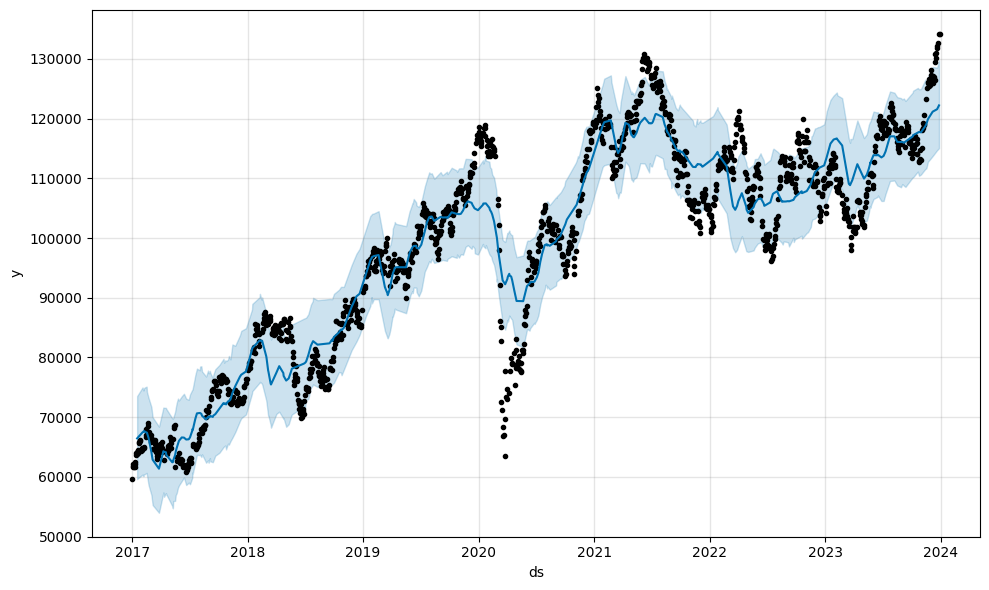

In [54]:
y_pred=m.predict(test_set)
m.plot(y_pred);
y_pred

In [58]:
print('MAE: {}'.format(metrics.mean_absolute_error(test_set['y'].values,y_pred['yhat'].values)))
print('RMSE: {}'.format(metrics.mean_squared_error(test_set['y'].values,y_pred['yhat'].values,squared=False)))

MAE: 4608.5107843228625
RMSE: 5966.582656265659


O MAE é uma métrica que representa a média absoluta das diferenças entre as previsões do modelo e os valores reais. No seu caso, o valor do MAE é aproximadamente 4608.51. Isso significa que, em média, as previsões do seu modelo estão distantes dos valores reais por cerca de 4608.51 unidades na mesma escala dos dados originais.
RMSE (Erro Quadrático Médio da Raiz):

O RMSE é uma métrica que leva em consideração a magnitude dos erros quadráticos. No seu caso, o valor do RMSE é aproximadamente 5966.58. Isso indica que, em média, as previsões do modelo estão distantes dos valores reais por cerca de 5966.58 unidades, penalizando erros maiores de forma mais significativa.